Training on fold [0/5]

bestTest = 0.2106675745
bestIteration = 9988

Training on fold [1/5]

bestTest = 0.2359396213
bestIteration = 9970

Training on fold [2/5]

bestTest = 0.2181043081
bestIteration = 9891

Training on fold [3/5]

bestTest = 0.2935878558
bestIteration = 9996

Training on fold [4/5]

bestTest = 0.2193052038
bestIteration = 9999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 7.4486629	test: 7.3742141	best: 7.3742141 (0)	total: 1.35ms	remaining: 13.5s
500:	learn: 0.2522451	test: 0.3107433	best: 0.3107433 (500)	total: 484ms	remaining: 9.17s
1000:	learn: 0.1734394	test: 0.2579553	best: 0.2579553 (1000)	total: 984ms	remaining: 8.84s
1500:	learn: 0.1381057	test: 0.2383321	best: 0.2383321 (1500)	total: 1.45s	remaining: 8.23s
2000:	learn: 0.1160381	test: 0.2284210	best: 0.2284210 (2000)	total: 2s	remaining: 7.97s
2500:	learn: 0.1000164	test: 0.2225605	best: 0.2225605 (2500)	total: 2.46s	remaining: 7.39s
3000:	learn: 0.0879574	test: 0.2192590	best: 0.2192590 (3000)	total: 2.93s	remaining: 6.83s
3500:	learn: 0.0782028	test: 0.2165706	best: 0.2165706 (3500)	total: 3.43s	remaining: 6.37s
4000:	learn: 0.0699047	test: 0.2143880	best: 0.2143879 (3997)	total: 3.9s	remaining: 5.84s
4500:	learn: 0.0628748	test: 0.2129273	best: 0.2129273 (4500)	total: 4.42s	remaining: 5.4s
5000:	learn: 0.0569529	test: 0.2118567	best: 0.2118564 (4999)	total: 4.88s	remaining: 4.88s


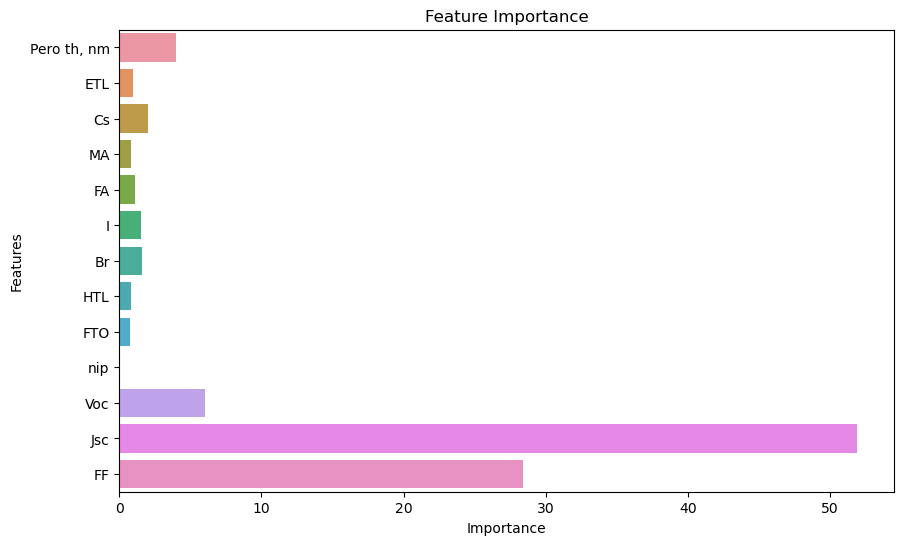

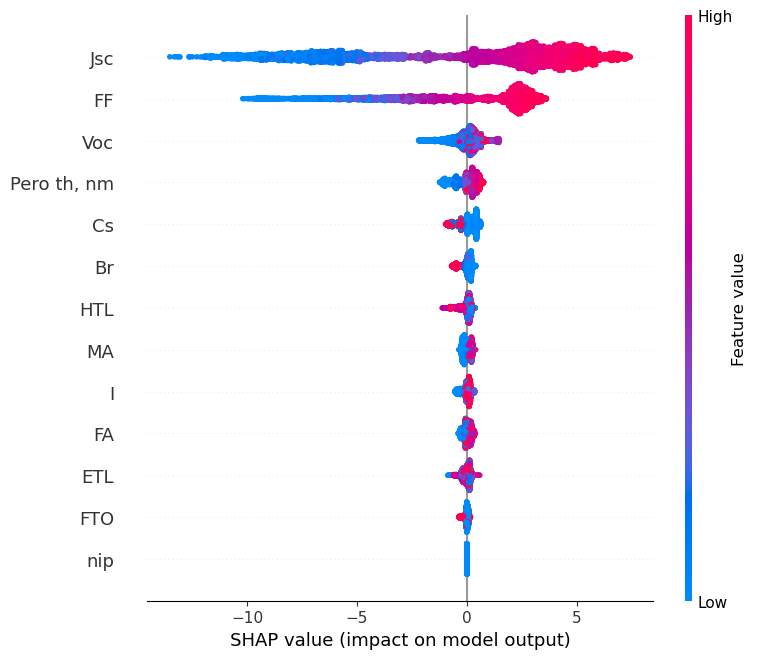

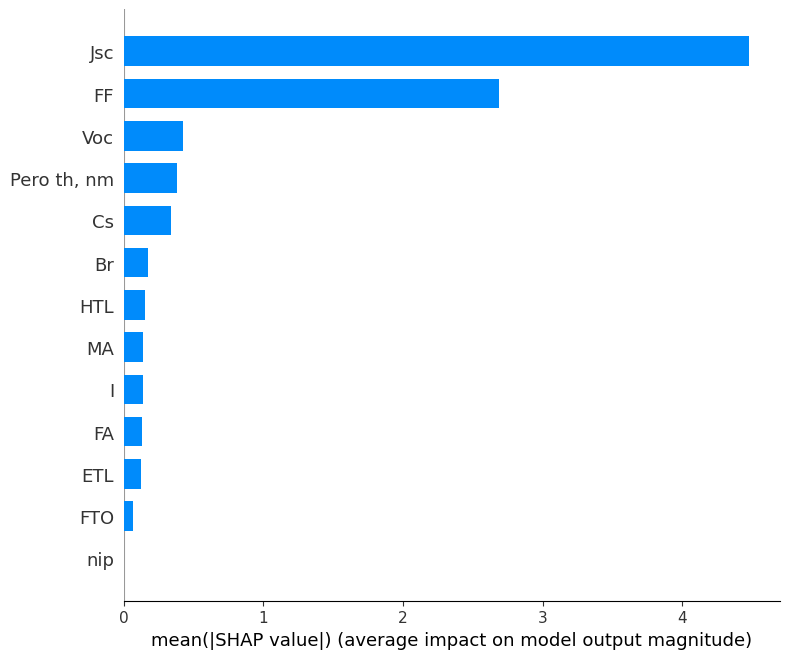

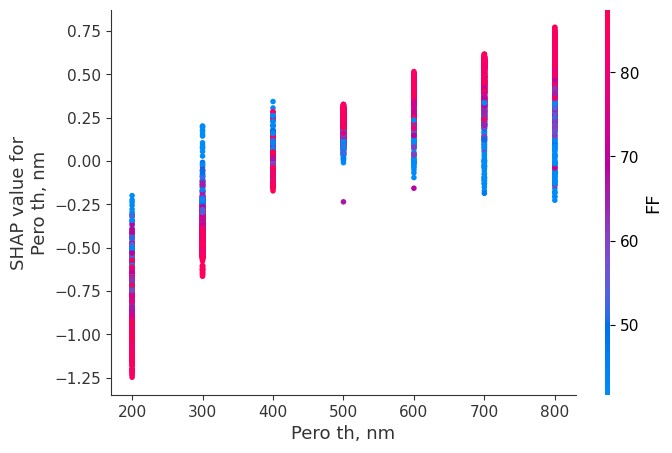

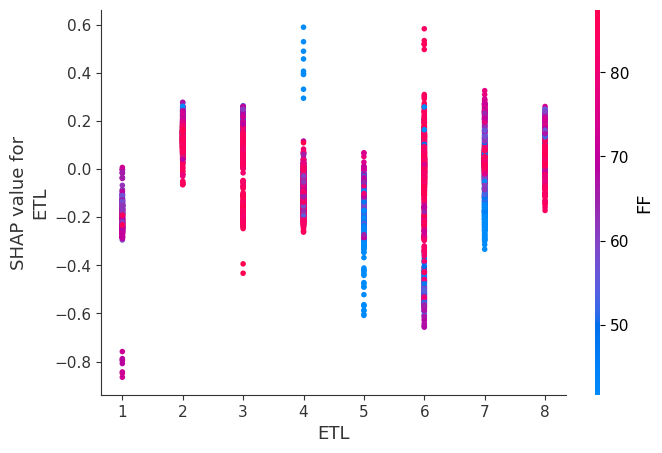

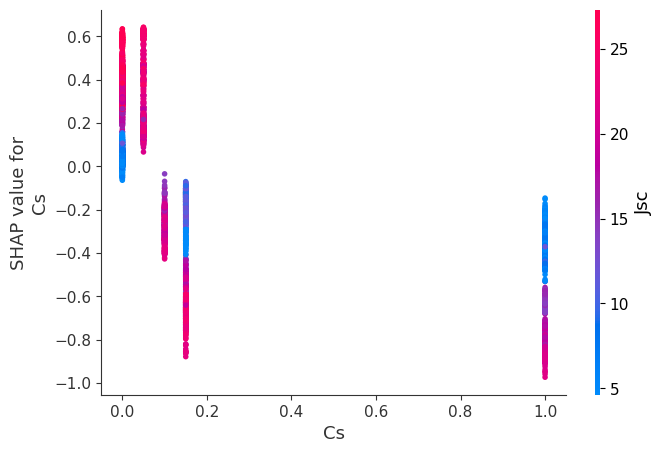

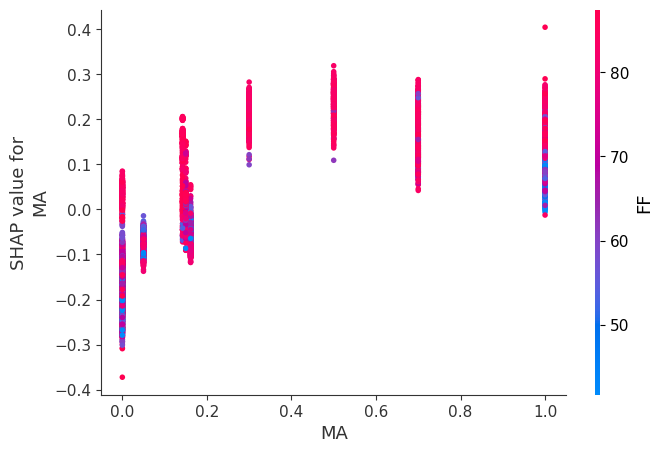

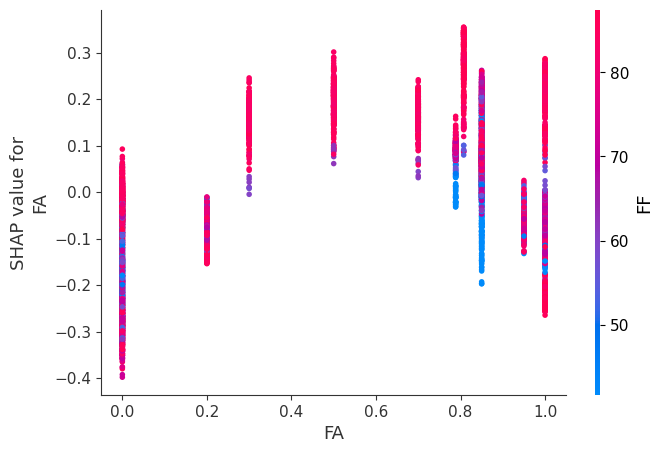

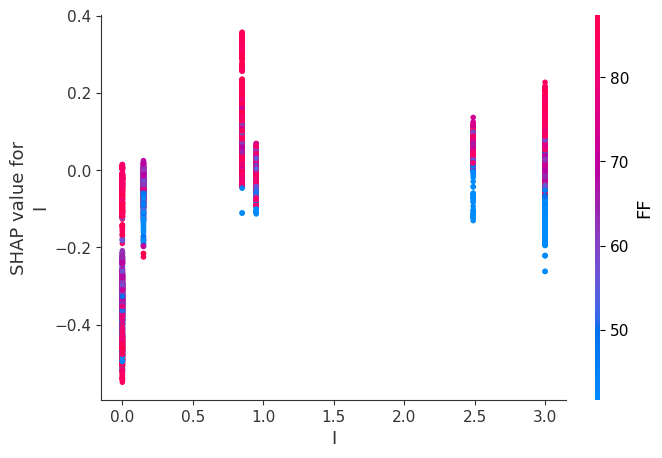

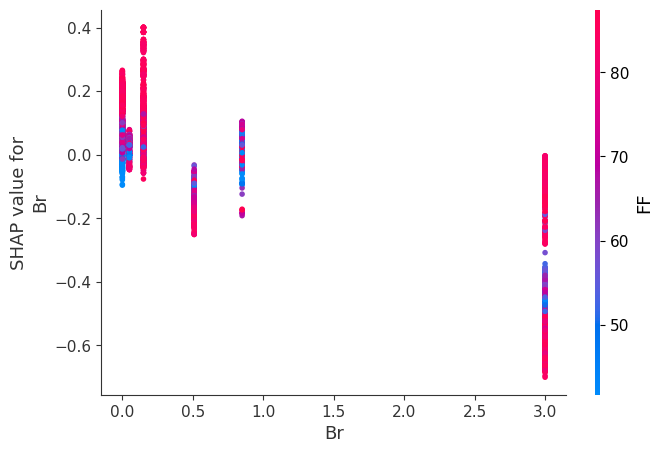

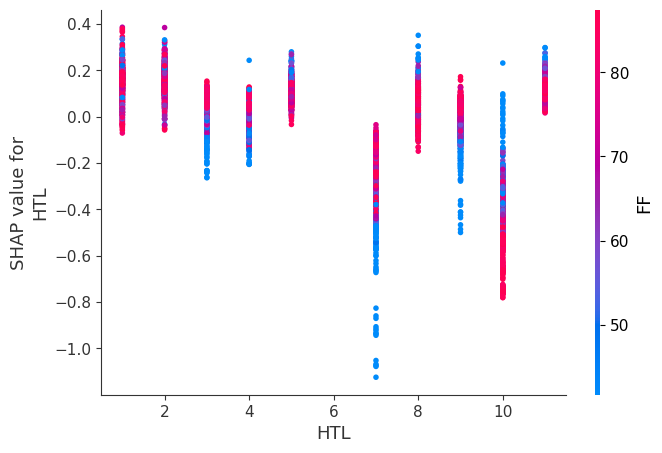

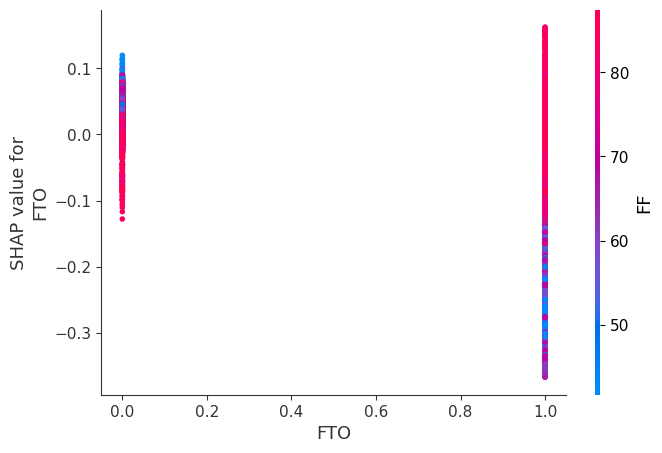

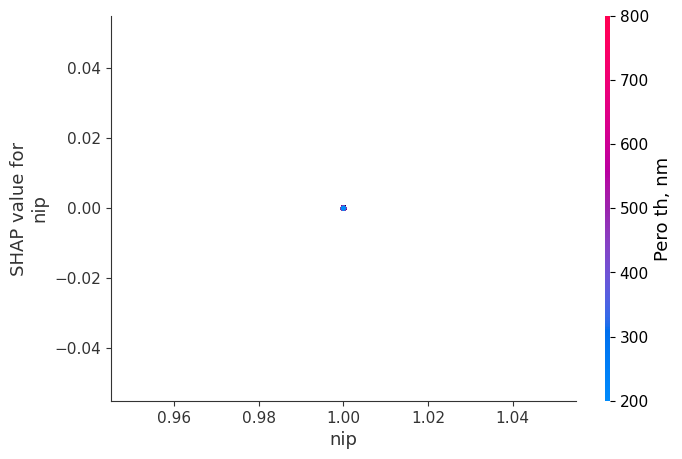

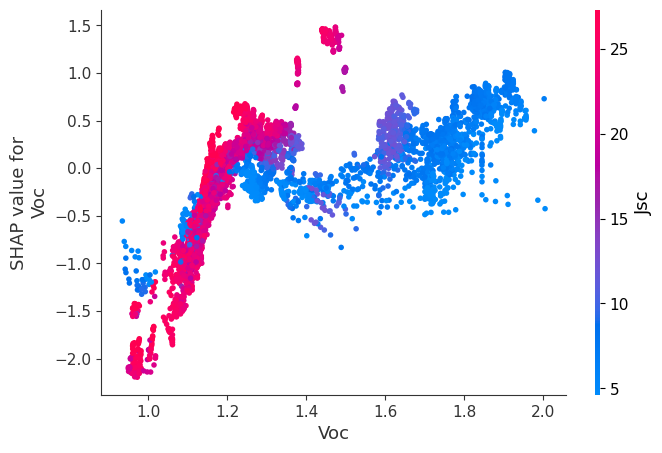

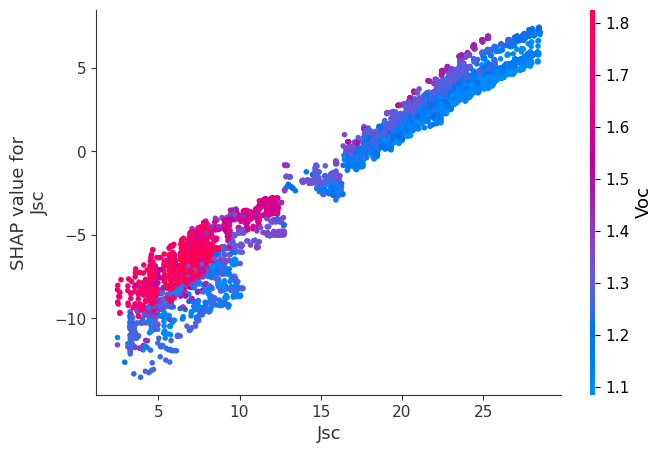

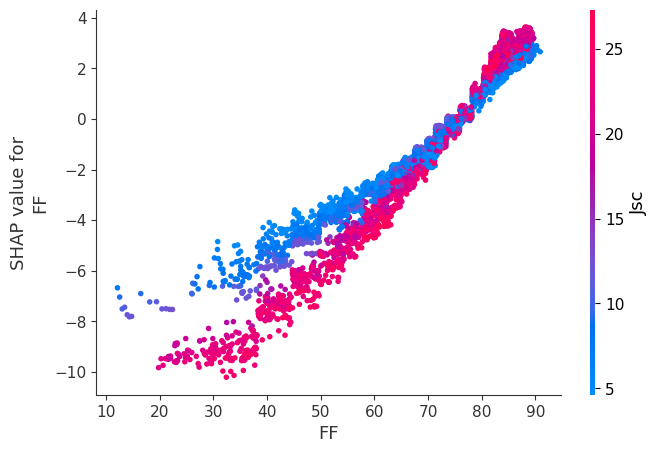

Loaded model parameters:
border_count: 32
depth: 7
iterations: 10000
l2_leaf_reg: 1
loss_function: RMSE
one_hot_max_size: 11
verbose: 500
R2 Score on test data: 0.9992490375922144


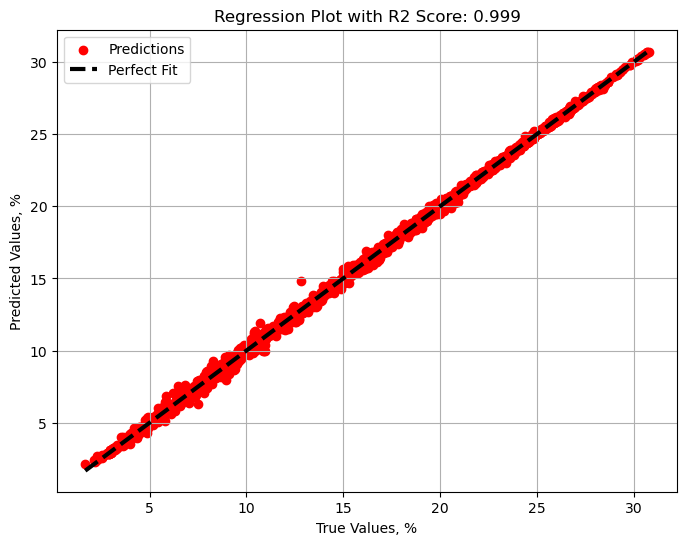

In [1]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load data
df = pd.read_excel("cell_simulation_results.xlsx")

# Features and target
X = df[['Pero th, nm', 'ETL', 'Cs', 'MA', 'FA', 'I', 'Br', 'HTL', 'FTO', 'nip', 'Voc', 'Jsc', 'FF']]
y = df[['PCE']]
cat_features = [1, 7, 8]

# Train / test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# CatBoost pools
train_pool = Pool(X_train, label=y_train, cat_features=cat_features)
val_pool = Pool(X_val, label=y_val, cat_features=cat_features)

# Model hyperparameters
params = {
    'iterations': 10000,
    'depth': 7,
    'l2_leaf_reg': 1,
    'one_hot_max_size': 11,
    'border_count': 32,
    'loss_function': 'RMSE',
    'verbose': 500
}

# Cross-validation
cv_results = cv(train_pool, params, fold_count=5, verbose=False)

# Model fit with the best hyperparams
best_model = CatBoostRegressor(**params)
best_model.fit(train_pool, eval_set=val_pool, verbose=500, plot=True)

# Evaluation
predictions = best_model.predict(X_val)
mse = mean_squared_error(y_val, predictions)
r2 = r2_score(y_val, predictions)
print(f"MSE: {mse}")
print(f"R2 Score: {r2}")

# Feature importances
feature_importances = best_model.get_feature_importance()
feature_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_names)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# SHAP analysis
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)
shap.summary_plot(shap_values, X, plot_type="bar")

# SHAP dependence
important_features = ['Pero th, nm', 'ETL', 'Cs', 'MA', 'FA', 'I', 'Br', 
                      'HTL', 'FTO', 'nip', 'Voc', 'Jsc', 'FF']
for feature in important_features:
    shap.dependence_plot(feature, shap_values, X)

# Model save 
# best_model.save_model("final_model_catboost.json", format="json") # uncomment this if necessary

# Load model
loaded_model = CatBoostRegressor()
loaded_model.load_model("final_model_catboost.json", format="json")

# Loaded model params
params_loaded = loaded_model.get_params()
print("Loaded model parameters:")
for param, value in params_loaded.items():
    print(f'{param}: {value}')

# R2-score
y_true = y_val
y_pred = loaded_model.predict(X_val)

r2 = r2_score(y_true, y_pred)
print(f"R2 Score on test data: {r2}")

# True vs. predict graph
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, color='red', label='Predictions')
plt.plot([min(y_true.values), max(y_true.values)], [min(y_true.values), max(y_true.values)], '--k', 
         linewidth=3, label='Perfect Fit')
plt.xlabel('True Values, %')
plt.ylabel('Predicted Values, %')
plt.title(f'Regression Plot with R2 Score: {r2:.3f}')
plt.legend()
plt.grid(True)
plt.show()
